In [1]:
!pip install graph-pes | tail -n 1

We now should have access to the ``graph-pes-train`` command. We can check this by running:

In [3]:
!graph-pes-train -h

usage: graph-pes-train [-h] [args ...]

Train a GraphPES model using PyTorch Lightning.

positional arguments:
  args        Config files and command line specifications. Config files
              should be YAML (.yaml/.yml) files. Command line specifications
              should be in the form nested^key=value. Final config is built up
              from these items in a left to right manner, with later items
              taking precedence over earlier ones in the case of conflicts.

optional arguments:
  -h, --help  show this help message and exit

Copyright 2023-24, John Gardner


In [26]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-17")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap17.xyz", train)
ase.io.write("val-cgap17.xyz", val)
ase.io.write("test-cgap17.xyz", test)


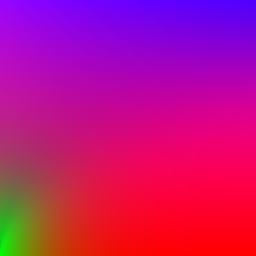

In [3]:
from load_atoms import view

view(train[0], show_bonds=True)

In [20]:
%%bash

if [ ! -f quickstart-cgap17.yaml ]; then
    wget https://raw.githubusercontent.com/jla-gardner/graph-pes/refs/heads/main/docs/source/quickstart/quickstart-cgap17.yaml
fi

In [21]:
!graph-pes-train quickstart-cgap17.yaml

Seed set to 42
[graph-pes INFO]: Set logging level to INFO
[graph-pes INFO]: Started training at 2024-10-29 13:38:35.892
[graph-pes INFO]: Output directory: graph-pes-results/nequip-for-cgap17
[graph-pes INFO]: 
Logging using WandbLogger(
  project="graph-pes-quickstart",
  id="nequip-for-cgap17",
  save_dir="graph-pes-results"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: jla-gardner. Use `wandb login --relogin` to force relogin
wandb: Run data is saved locally in graph-pes-results/wandb/run-20241029_133836-nequip-for-cgap17
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run nequip-for-cgap17
wandb: ⭐️ View project at https://wandb.ai/jla-gardner/graph-pes-quickstart
wandb: 🚀 View run at https://wandb.ai/jla-gardner/graph-pes-quickstart/runs/nequip-for-cgap17
[graph-pes INFO]: Logging to graph-pes-results/nequip-for-cgap17/logs/rank-0.log
[graph-pes INFO]: 
model:
  

In [22]:
from graph_pes.models import load_model

best_model = load_model("graph-pes-results/nequip-for-cgap17/model.pt")
best_model


AdditionModel(
  offset=FixedOffset({'C': -148.0}, trainable=False),
  many-body=NequIP(
    (Z_embedding): AtomicOneHot(elements=['C'])
    (initial_node_embedding): PerElementEmbedding(dim=16, elements=['C'])
    (edge_embedding): SphericalHarmonics(1x1o -> 1x0e+1x1o+1x2e)
    (layers): UniformModuleList(
      (0): NequIPMessagePassingLayer(
        (pre_message_linear): Linear(16x0e -> 16x0e | 256 weights)
        (message_tensor_product): TensorProduct(16x0e x 1x0e+1x1o+1x2e -> 16x0e+16x1o+16x2e | 48 paths | 48 weights)
        (weight_generator): HaddamardProduct(
          (components): ModuleList(
            (0): Sequential(
              (0): Bessel(n_features=8, cutoff=3.7, trainable=True)
              (1): MLP(8 → 8 → 8 → 48, activation=SiLU())
            )
            (1): PolynomialEnvelope(cutoff=3.7, p=6)
          )
        )
        (aggregation): SumNeighbours()
        (non_linearity): Gate (28x0e+8x1o+4x2e -> 16x0e+8x1o+4x2e)
        (post_message_linear): Linear

In [27]:
from graph_pes.atomic_graph import AtomicGraph

test_graphs = [
    AtomicGraph.from_ase(structure, cutoff=3.7) for structure in test
]
test_graphs[0]

AtomicGraph(
    atoms=64,
    edges=1124,
    has_cell=True,
    cutoff=3.7,
    properties=['energy', 'forces']
)

Our predictions look like this:

In [28]:
{
    k: v.shape
    for k, v in best_model.get_all_PES_predictions(test_graphs[0]).items()
}


{'energy': torch.Size([]),
 'forces': torch.Size([64, 3]),
 'local_energies': torch.Size([64]),
 'stress': torch.Size([3, 3])}

We can see from a single data point that our model has done a reasonable job of learning the potential:

In [29]:
best_model.predict_energy(test_graphs[0]), test_graphs[0].properties["energy"]

(tensor(-9996.1914, grad_fn=<AddBackward0>), tensor(-9998.7080))

``graph-pes`` provides a few utility functions for visualising model performance:

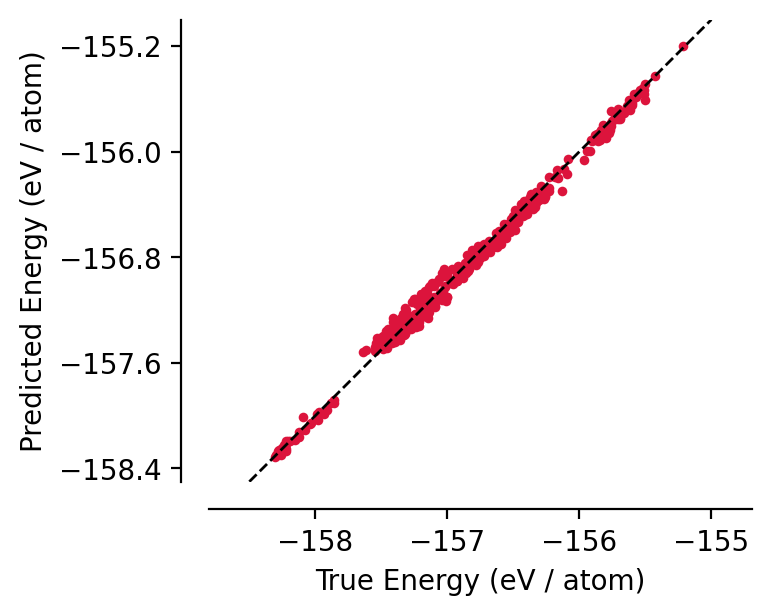

In [30]:
import matplotlib.pyplot as plt
from graph_pes.atomic_graph import divide_per_atom
from graph_pes.utils.analysis import parity_plot

%config InlineBackend.figure_format = 'retina'

parity_plot(
    best_model,
    test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson",
)
plt.xlim(-158.5, -155)
plt.ylim(-158.5, -155);

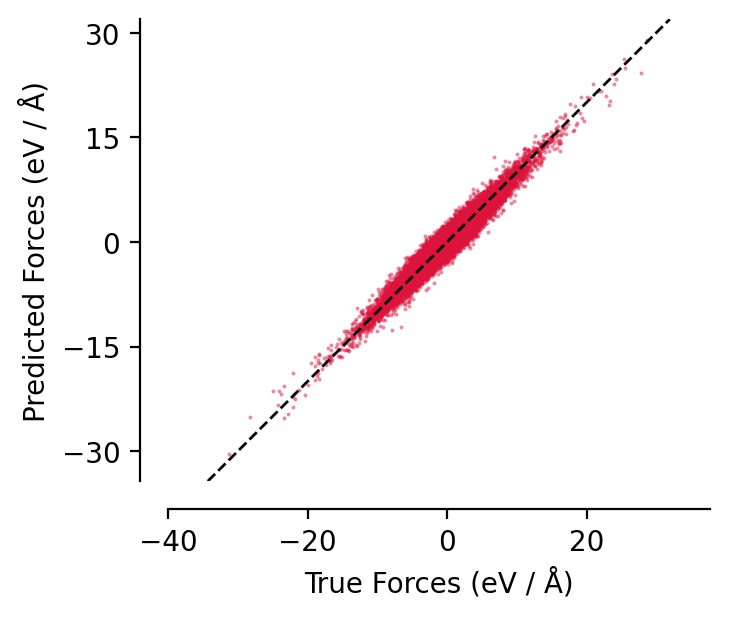

In [31]:
parity_plot(
    best_model,
    test_graphs,
    property="forces",
    units="eV / Å",
    lw=0,
    s=2,
    alpha=0.5,
    color="crimson"
)

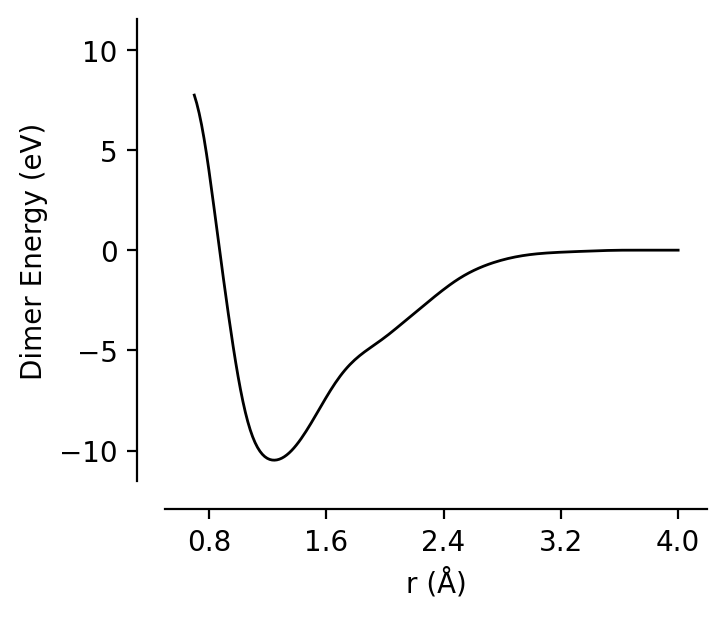

In [33]:
from graph_pes.utils.analysis import dimer_curve

dimer_curve(best_model, system="CC", units="eV", rmin=0.7, rmax=4.0);


In [34]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-20U")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap20u.xyz", train)
ase.io.write("val-cgap20u.xyz", val)
ase.io.write("test-cgap20u.xyz", test)

Output()

We can see that the ``C-GAP-20U`` dataset clearly has labels with a different arbitrary offset to the ``C-GAP-17`` dataset. 

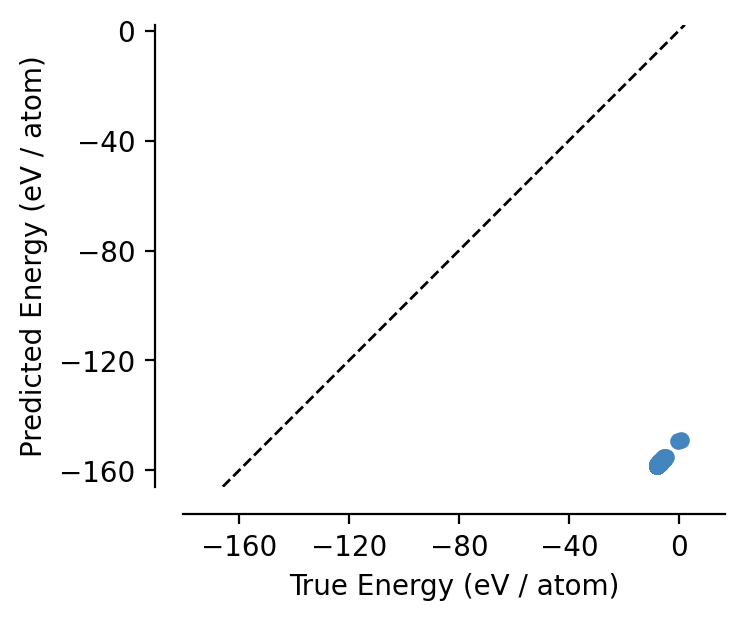

In [35]:
cgap20_test_graphs = [
    AtomicGraph.from_ase(structure, cutoff=3.7) for structure in test
]

parity_plot(
    best_model,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
)

In fact, the ``energy`` labels on ``C-GAP-20U`` are formation energies, and hence the offset we used above is no longer necessary:

In [36]:
from graph_pes.models import AdditionModel

assert isinstance(best_model, AdditionModel)
underlying_nequip = best_model["many-body"]
type(underlying_nequip)

graph_pes.models.e3nn.nequip.NequIP

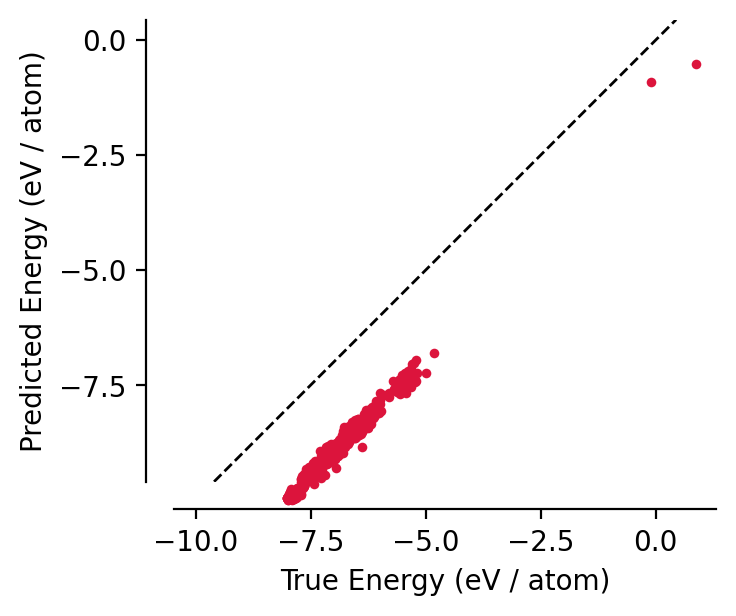

In [43]:
parity_plot(
    underlying_nequip,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson"
)

In [41]:
%%bash

graph-pes-train finetune-cgap20u.yaml \
    model^graph_pes.models.load_model_component^path=graph-pes-results/nequip-for-cgap17/model.pt


Seed set to 42
[graph-pes INFO]: Set logging level to INFO
[graph-pes INFO]: Started training at 2024-10-29 13:53:00.598
[graph-pes INFO]: Output directory: graph-pes-results/finetune-nequip-for-cgap20u
[graph-pes INFO]: 
Logging using WandbLogger(
  project="graph-pes-quickstart",
  id="finetune-nequip-for-cgap20u",
  save_dir="graph-pes-results"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: jla-gardner. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in graph-pes-results/wandb/run-20241029_135301-finetune-nequip-for-cgap20u
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run finetune-nequip-for-cgap20u
wandb: ⭐️ View project at https://wandb.ai/jla-gardner/graph-pes-quickstart
wandb: 🚀 Vie

This fine-tuning process has aligned the model predictions with the ``C-GAP-20U`` formation energies:

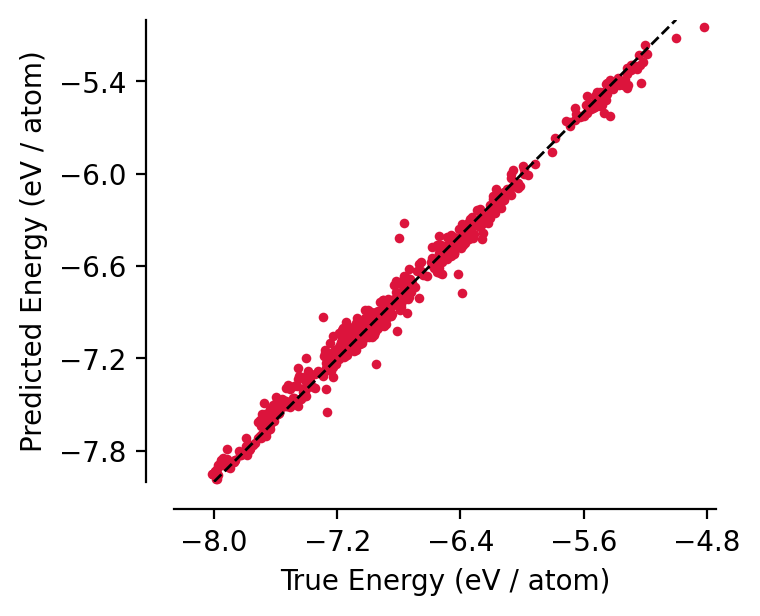

In [42]:
fine_tuned_model = load_model(
    "graph-pes-results/finetune-nequip-for-cgap20u/model.pt"
)
parity_plot(
    fine_tuned_model,
    cgap20_test_graphs,
    property="energy",
    transform=divide_per_atom,
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson"
)
plt.xlim(-8, -5)
plt.ylim(-8, -5);